# Loading/Rescaling Image Data

## Perform standard imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from PIL import Image
from IPython.display import display

## Create a DataFrame

#### Create a list of image filenames

#### Create a DataFrame of image sizes (width x height)
It's worth noting that <tt>Image.open()</tt> doesn't read the entire image into memory, so it's a reasonable way to get image sizes. Still, this can take awhile.

In [4]:
path = './Datasets/BSD500_COCO1000_train_val/train/'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+img)
        
print('Images: ',len(img_names))

Images:  1200


In [5]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  1200
Rejects: 0


In [6]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    1200.000000
mean      554.449167
std       104.779091
min       319.000000
25%       481.000000
50%       640.000000
75%       640.000000
max       640.000000
Name: 0, dtype: float64

In [7]:
# Run summary statistics on image heights
df[1].describe()

count    1200.000000
mean      466.945000
std       100.312258
min       256.000000
25%       425.000000
50%       480.000000
75%       486.250000
max       640.000000
Name: 1, dtype: float64

## Image Pre-processing
Transformation of one image

In [8]:
surf = Image.open(img_names[12])
print(surf)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x640 at 0x1A2C213E10>


In [9]:
r, g, b = surf.getpixel((0, 0))
print(r,g,b)

121 117 108


torch.Size([3, 640, 427])


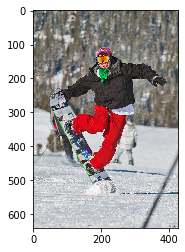

In [10]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(surf)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [62]:
color = ('b','g','r')
liste_histr = []
nx = 200

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img = cv.imread(folder+img,cv.IMREAD_COLOR)
        # Etape 1 : obtenir l'histogramme
        for i,col in enumerate(color):
            histr = cv.calcHist([img],[i],None,[256],[0,256]).squeeze()
            # convolution
            # y = smooth(histr,5)
            # Savitzky-Golay
            y = savgol_filter(histr, 21, 5)
            # interpolation pour nx points
            x = np.linspace(0,1,256)
            xp = np.linspace(0,1,nx)
            yp = np.interp(xp, x, y, period=2*np.pi)
            # normalisation
            yp = yp/np.linalg.norm(yp)
            # enregistrement
            liste_histr.append(yp)
        


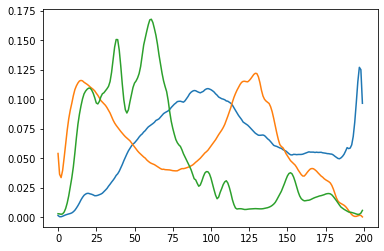

In [63]:
plt.plot(liste_histr[2])
plt.plot(liste_histr[200])
plt.plot(liste_histr[2000])

## Traitement - courbe C^infini et bruit gaussien

#### Méthode filtre Savitzky-Golay


In [64]:
from scipy.signal import savgol_filter
y = histr
yhat = savgol_filter(y, 21, 5)

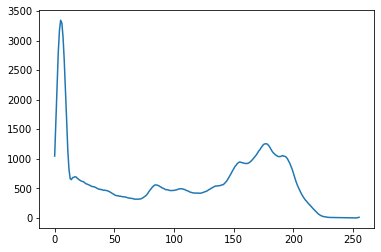

In [65]:
plt.plot(yhat)
#plt.plot(y,'+')

#### Méthode Fourrier


In [66]:
import scipy.fftpack

N = 256
x = np.linspace(0,2*np.pi,256)

w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2

cutoff_idx = spectrum < (spectrum.max()/100)
w2 = w.copy()
w2[cutoff_idx] = 0

yhat2 = scipy.fftpack.irfft(w2)

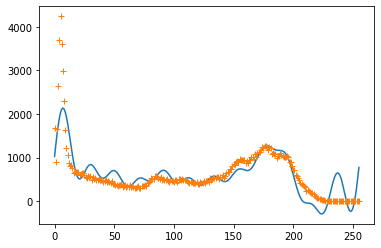

In [67]:
plt.plot(yhat2)
plt.plot(y,'+')

#### Méthode convolution noyau C^infini

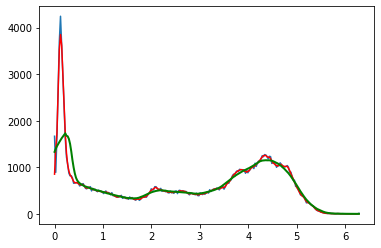

In [68]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


plt.plot(x, y)
plt.plot(x, smooth(y,3), 'r-')
plt.plot(x, smooth(y,19), 'g-', lw=2)

#### Comparaison

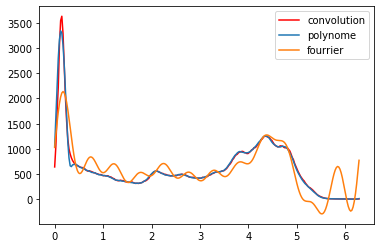

In [69]:
plt.plot(x, smooth(y,4), 'r-', label= "convolution")
plt.plot(x,yhat, label = "polynome")
plt.plot(x,yhat2, label = "fourrier")
plt.legend()

## Enregistrement et fin

In [73]:
Npoint = len(liste_histr)
np.savetxt('data_lisse.csv', liste_histr, delimiter=', ', fmt='%12.8f')